# Setting up the spark context/session.

In [1]:
pip show pyspark

Name: pysparkNote: you may need to restart the kernel to use updated packages.
Version: 3.0.3
Summary: Apache Spark Python API

Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: c:\users\samru\appdata\local\programs\python\python310\lib\site-packages
Requires: py4j
Required-by: 


In [2]:
import pyspark

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark=SparkSession.builder.appName('practicenew').getOrCreate()

In [5]:
spark

## Reading the csv dataset into spark and using spark DataFrame to manipulate.

In [6]:
init_df= spark.read.csv('docs/telco_customer_churn_dataset.csv', header=True, inferSchema=True)

In [7]:
init_df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [8]:
type(init_df)

pyspark.sql.dataframe.DataFrame

In [9]:
init_df.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [10]:
##dropping off the customerID column as it won't be useful for our analysis.
pre_df1 = init_df.drop(init_df['customerID'])
pre_df1.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [11]:
##Converting the Total Charges column from string to double type.
from pyspark.sql.types import DoubleType
pre_df1 = pre_df1.withColumn("TotalCharges", pre_df1['TotalCharges'].cast(DoubleType()))
pre_df1.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [12]:
##Function to find the number of null values in the dataframe if it exists.
from pyspark.sql.functions import col,isnan,when,count
pre_df2=pre_df1.select([count(when(col(c).contains('None') |    \
                                    col(c).contains('NULL') | \
                                    (col(c) == '') | \
                                    col(c).isNull() | \
                                    isnan(c), c
    )).alias(c)
    for c in pre_df1.columns])

pre_df2.show()


+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0|            0|             0|          11|   

We can see that the Total Charges has 11 null/NaN values.

In [13]:
##Removes the null values.
pre_df1 = pre_df1.na.drop("any")

In [14]:
##Verify if the null values are removed.
pre_df2_temp=pre_df1.select([count(when(col(c).contains('None') |    \
                                    col(c).contains('NULL') | \
                                    (col(c) == '') | \
                                    col(c).isNull() | \
                                    isnan(c), c
    )).alias(c)
    for c in pre_df1.columns])

pre_df2_temp.show()


+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0|            0|             0|           0|   

We can see that the category "No phone service" and "No internet service" don't really provide much value and hence we will convert them to "No"

In [15]:
pre_df1.groupBy("MultipleLines").count().show()
pre_df1.groupBy("OnlineSecurity").count().show()
pre_df1.groupBy("OnlineBackup").count().show()
pre_df1.groupBy("DeviceProtection").count().show()
pre_df1.groupBy("TechSupport").count().show()
pre_df1.groupBy("StreamingTV").count().show()
pre_df1.groupBy("StreamingMovies").count().show()

+----------------+-----+
|   MultipleLines|count|
+----------------+-----+
|No phone service|  680|
|              No| 3385|
|             Yes| 2967|
+----------------+-----+

+-------------------+-----+
|     OnlineSecurity|count|
+-------------------+-----+
|                 No| 3497|
|                Yes| 2015|
|No internet service| 1520|
+-------------------+-----+

+-------------------+-----+
|       OnlineBackup|count|
+-------------------+-----+
|                 No| 3087|
|                Yes| 2425|
|No internet service| 1520|
+-------------------+-----+

+-------------------+-----+
|   DeviceProtection|count|
+-------------------+-----+
|                 No| 3094|
|                Yes| 2418|
|No internet service| 1520|
+-------------------+-----+

+-------------------+-----+
|        TechSupport|count|
+-------------------+-----+
|                 No| 3472|
|                Yes| 2040|
|No internet service| 1520|
+-------------------+-----+

+-------------------+-----+
|       

In [16]:
from pyspark.sql.functions import regexp_replace
pre_df1=pre_df1.withColumn('MultipleLines', regexp_replace('MultipleLines', 'No phone service', 'No'))
pre_df1=pre_df1.withColumn('OnlineSecurity', regexp_replace('OnlineSecurity', 'No internet service', 'No'))
pre_df1=pre_df1.withColumn('OnlineBackup', regexp_replace('OnlineBackup', 'No internet service', 'No'))
pre_df1=pre_df1.withColumn('DeviceProtection', regexp_replace('DeviceProtection', 'No internet service', 'No'))
pre_df1=pre_df1.withColumn('TechSupport', regexp_replace('TechSupport', 'No internet service', 'No'))
pre_df1=pre_df1.withColumn('StreamingTV', regexp_replace('StreamingTV', 'No internet service', 'No'))
pre_df1=pre_df1.withColumn('StreamingMovies', regexp_replace('StreamingMovies', 'No internet service', 'No'))

In [17]:
##Verifying whether our conversion is successful.
pre_df1.groupBy("MultipleLines").count().show()
pre_df1.groupBy("OnlineSecurity").count().show()
pre_df1.groupBy("OnlineBackup").count().show()
pre_df1.groupBy("DeviceProtection").count().show()
pre_df1.groupBy("TechSupport").count().show()
pre_df1.groupBy("StreamingTV").count().show()
pre_df1.groupBy("StreamingMovies").count().show()

+-------------+-----+
|MultipleLines|count|
+-------------+-----+
|           No| 4065|
|          Yes| 2967|
+-------------+-----+

+--------------+-----+
|OnlineSecurity|count|
+--------------+-----+
|            No| 5017|
|           Yes| 2015|
+--------------+-----+

+------------+-----+
|OnlineBackup|count|
+------------+-----+
|          No| 4607|
|         Yes| 2425|
+------------+-----+

+----------------+-----+
|DeviceProtection|count|
+----------------+-----+
|              No| 4614|
|             Yes| 2418|
+----------------+-----+

+-----------+-----+
|TechSupport|count|
+-----------+-----+
|         No| 4992|
|        Yes| 2040|
+-----------+-----+

+-----------+-----+
|StreamingTV|count|
+-----------+-----+
|         No| 4329|
|        Yes| 2703|
+-----------+-----+

+---------------+-----+
|StreamingMovies|count|
+---------------+-----+
|             No| 4301|
|            Yes| 2731|
+---------------+-----+



In [18]:
pre_df1.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Now we will calculate if the total charges is equal to tenure * monthly_charges

In [19]:
pre_df_final = pre_df1.withColumn("calculatedCharges", pre_df1.tenure*pre_df1.MonthlyCharges)
pre_df_final.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- calculatedCharges: double (nullable = true)



In [20]:
pre_df_final.show()

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------------+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn| calculatedCharges|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------------+
|Female|            0|    Yes|        No|     1|          No|           No|            DSL|            No|         Yes|              No|         No|   

In [21]:
##creating new column to check the conditions if the calcualatedCharges is lesser, greater or equal to totalCharges given.
from pyspark.sql.functions import when, lit
pre_df_final = pre_df_final.withColumn("TotalChargesStatus", when((pre_df_final.TotalCharges > pre_df_final.calculatedCharges), lit("greater")) \
    .when((pre_df_final.TotalCharges < pre_df_final.calculatedCharges), lit("lesser")).otherwise(lit("equal")))

In [22]:
pre_df_final.show(5)

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------------+------------------+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn| calculatedCharges|TotalChargesStatus|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------------+------------------+
|Female|            0|    Yes|        No|     1|          No|           No|            DSL|   

Here we can see that the total charges are not exactly computed as (tenure X Monthly charges) in the dataset. As per our calculations, we can see that only 614 transactions are equal to the above logic, the rest of the transactions are either greater or lesser in value. This means that the telco company has provided discounts for 3214 transactions and charged more(payment delay fines, or other value add charges) to 3204 transactions.

This seems deliberate and hence we won't be making any new changes to the TotalCharges column and leave it as is in the dataset. No data cleaning will be applied for this.


In [23]:
pre_df_final.groupBy("TotalChargesStatus").count().show()

+------------------+-----+
|TotalChargesStatus|count|
+------------------+-----+
|             equal|  614|
|           greater| 3204|
|            lesser| 3214|
+------------------+-----+



In [24]:
##Removing calculatedCharges and TotalChargesStatus columns as we are done with our analysis and we won't be needing it anymore.
cols=("calculatedCharges", "TotalChargesStatus")
pre_df_final=pre_df_final.drop(*cols)
pre_df_final.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [26]:
#Convertin the predictor variable in a binary numeric variable. This is helpful if we are to build a model to predict churn.
clean_df=pre_df_final.withColumn('Churn', when((pre_df_final.Churn == 'Yes'),lit(1)).otherwise(lit(0)))

In [27]:
clean_df.show(5)

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|Female|            0|    Yes|        No|     1|          No|           No|            DSL|            No|         Yes|              No|         No|         No|             No|Month-to-month|             Yes|

Converting our manipulated dataframe to pandas and then eventually to csv format.

In [29]:
clean_df.toPandas().to_csv('cleaned_telco_customer_churn.csv', index=False)

# Visualizations of the pyspark dataframe

As spark dataframes are distributed, it is difficult and computationally expensive to visualize the dataframes directly as they need to be aggregated and each node should apply the visualization.

* Databricks interactive environment has a visualization feature called as *display()* that allows you to visualize the spark dataframes directly.
* Apache Zepplin notebook too has a function that allows you to visualize the spark dataframes directly.
* In Jupyter notebook - the best case scenario is if the dataset is small enough, convert the spark dataframe to Pandas and visualize using matplotlib library

In [30]:
import matplotlib.pyplot as plt
import seaborn as sb

<AxesSubplot:ylabel='SeniorCitizen'>

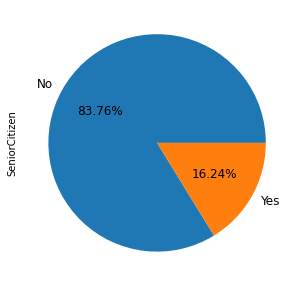

In [32]:
##Converted to Pandas and then ran the pandas operations with matplotlib to plot a pie chart.
clean_df.toPandas().SeniorCitizen.value_counts(normalize=True).mul(100).plot.pie(autopct='%.2f%%', labels=['No', 'Yes'], figsize=(5,5), fontsize=12)

In [33]:
clean_df.groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1| 1869|
|    0| 5163|
+-----+-----+



In [34]:
df_to_plot=clean_df.groupBy("Churn").count()
x=df_to_plot.toPandas()["Churn"].values.tolist()
y=df_to_plot.toPandas()["count"].values.tolist()

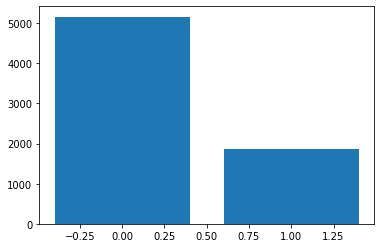

In [45]:
plt.bar(x,y)
plt.show()

<AxesSubplot:title={'center':'Gender distribution in percentage'}, xlabel='Gender', ylabel='% Customers'>

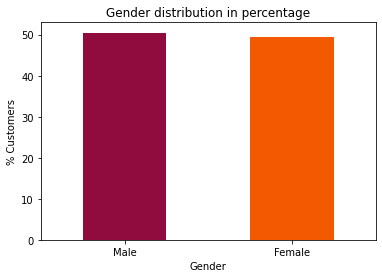

In [41]:
colors = ['#900C3F', '#F25900']
clean_df.toPandas().gender.value_counts(normalize=True).mul(100).plot(xlabel="Gender", ylabel="% Customers", kind="bar", rot=0, title="Gender distribution in percentage", color=colors)

<AxesSubplot:title={'center':'Gender distribution in percentage'}, xlabel='Gender', ylabel='% Customers'>

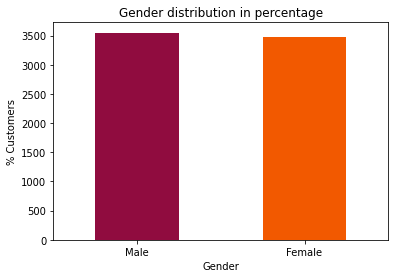

In [42]:
colors = ['#900C3F', '#F25900']
clean_df.toPandas().gender.value_counts().plot(xlabel="Gender", ylabel="% Customers", kind="bar", rot=0, title="Gender distribution in percentage", color=colors)

In [43]:
clean_df.toPandas().gender.value_counts()

Male      3549
Female    3483
Name: gender, dtype: int64